# Test out LLaMA models

_Early test results. Don't take it too seriously._

**GPU specs**

Works:
- NVIDIA A100

Still trying:
- NVIDIA V100
- NVIDIA T4

**Model sizes**

Works:
- 7B

Not tested:
- 13B
- 33B
- 65B

Trying to verify the claims in the paper:

> More importantly, the LLaMA-13B is also competitive on these benchmarks with GPT-3 and Chinchilla, despite being 5-10× smaller. This model runs on a single V100 GPU during inference.

Not a very strong start. Bump into issues here and there during testing. Known unknowns 😆

---

##### Disclaimer

_This model and (all language models) has the potential to generate undesirable content, especially if prompted to do so. We are working on making our models as helpful and non-toxic as possible, but there is still a lot of work to be done on this front. This is intended for developers on the project to do early evaluations. Use at your own risk._

<a href="https://colab.research.google.com/github/cedrickchee/llama/blob/main/notebooks/vi_LLaMA_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code translated from download.sh
PRESIGNED_URL="" # replace with presigned url from email
TARGET_FOLDER="./model/vi"
model_sizes = ["7B"]
N_SHARD_DICT = {
    "7B": 0
}

PyTorch Distributed env vars.

In [ ]:
%env RANK=0
%env WORLD_SIZE=1
%env MASTER_ADDR=localhost
%env MASTER_PORT=9994

env: RANK=0
env: WORLD_SIZE=1
env: MASTER_ADDR=localhost
env: MASTER_PORT=9994


## Install all the needed dependencies

In [ ]:
!mkdir model

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=0c3e6289a9285751a3a33e79b06d52a92c848d4ee1f3e6ff065157f47f529b6e
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


## Download model

Once download completed successfully, you will get these files and folder structure:

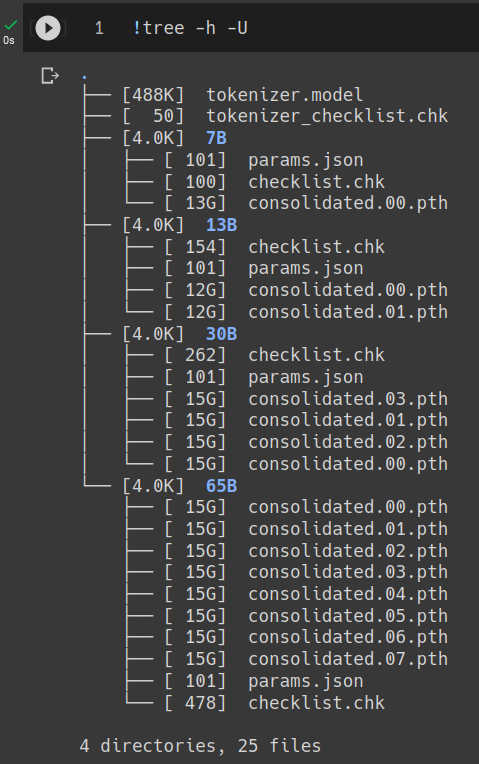

### 1. Download tokenizer

In [ ]:
import wget
import os

In [ ]:
# Script copied from download.sh
wget.download(PRESIGNED_URL.replace("*", "tokenizer.model"), out=f'{TARGET_FOLDER}/tokenizer.model')
wget.download(PRESIGNED_URL.replace("*", "tokenizer_checklist.chk"), out=f'{TARGET_FOLDER}/tokenizer_checklist.chk')

In [ ]:
# Script copied from download.sh
!(cd {TARGET_FOLDER} && md5sum -c tokenizer_checklist.chk)
%cd {TARGET_FOLDER}

tokenizer.model: OK


### 2. Download model weights

In [ ]:
# Code translated from download.sh
for model_size in model_sizes:
  print("Downloading", model_size)

  if not os.path.exists(f"./{model_size}"):
    os.mkdir(f"./{model_size}")
  for i in range(N_SHARD_DICT[model_size] + 1):
    if not os.path.exists(f"{model_size}/consolidated.0{i}.pth"):
      print(
        wget.download(PRESIGNED_URL.replace("*", f"{model_size}/consolidated.0{i}.pth"), out=f"{model_size}/consolidated.0{i}.pth")
      )
    else:
      print(f"found {model_size}/consolidated.0{i}.pth")
  print(
    wget.download(PRESIGNED_URL.replace("*", f"{model_size}/params.json"), out=f"{model_size}/params.json")
  )
  print(
    wget.download(PRESIGNED_URL.replace("*", f"{model_size}/checklist.chk"), out=f"{model_size}/checklist.chk")
  )

7B/params.json
7B/checklist.chk


In [ ]:
!cd 7B && md5sum -c checklist.chk

consolidated.00.pth: OK
params.json: OK


In [ ]:
!git clone https://github.com/facebookresearch/llama.git

Cloning into 'llama'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 17 (delta 1), reused 1 (delta 1), pack-reused 9
Unpacking objects: 100% (17/17), 25.64 KiB | 898.00 KiB/s, done.


In [ ]:
!cd llama && pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 KB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332138 sha256=b380dc5517b88755246f601cc8d4ee86ef9a1f892a614d18307930846203b413
  Stored in directory: /root/.cache/pip/wheels/b8/02/9b/dc7d4ff5145afdd28f456dae6605a46619af0370eca30d8d7e
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=37da1a8c6e69f886376c76b7b2573ff9e7b608771f47da929b773d9a057d2647
  Stored in directory: /r

In [ ]:
!cd llama && pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/model/llama
  Preparing metadata (setup.py) ... done
  Running setup.py develop for llama


In [ ]:
!cd llama && torchrun --nproc_per_node 1 example.py --ckpt_dir ../7B --tokenizer_path ../tokenizer.model

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loading
Loaded in 15.39 seconds
The capital of Germany is the city of Berlin. Berlin is one of the most important cities in Europe. Many people from all over the world come to visit the city and have an incredible time.
You can always have a good time in Berlin. From the many museums to the opera, from the historical monuments to the beautiful parks, you will have a great time. You can always find something to do and see in Berlin.
The city of Berlin is the capital of the German federal republic. The city is in the center of Germany. The city is the third largest city in Germany, and the 9th largest city in the European Union. Berlin has about 3.5 million people.
Berlin is a very important city in Europe. It is one of the most visited cities in the world. Berlin has many historical monuments, and many museums. There are many things to see and do in Berlin.
Berlin has a very mode

### Example of inference

In [ ]:
%cd llama

/content/model/llama/llama


The following code came from llama repo but with my modifications: https://github.com/cedrickchee/llama/blob/main/example.py

In [ ]:
from typing import Tuple
import os
import sys
import torch
import fire
import time
import json

from pathlib import Path

from fairscale.nn.model_parallel.initialize import initialize_model_parallel

from llama import ModelArgs, Transformer, Tokenizer, LLaMA

In [ ]:
def setup_model_parallel() -> Tuple[int, int]:
    local_rank = int(0)
    world_size = int(1)

    torch.distributed.init_process_group("nccl")
    initialize_model_parallel(world_size)
    torch.cuda.set_device(local_rank)

    # seed must be the same in all processes
    torch.manual_seed(1)
    return local_rank, world_size


def load(ckpt_dir: str, tokenizer_path: str, local_rank: int, world_size: int) -> LLaMA:
    start_time = time.time()
    checkpoints = sorted(Path(ckpt_dir).glob("*.pth"))
    assert (
        world_size == len(checkpoints)
    ), f"Loading a checkpoint for MP={len(checkpoints)} but world size is {world_size}"
    ckpt_path = checkpoints[local_rank]
    print("Loading")
    checkpoint = torch.load(ckpt_path, map_location="cpu")
    with open(Path(ckpt_dir) / "params.json", "r") as f:
        params = json.loads(f.read())

    model_args: ModelArgs = ModelArgs(max_seq_len=1024, max_batch_size=32, **params)
    tokenizer = Tokenizer(model_path=tokenizer_path)
    model_args.vocab_size = tokenizer.n_words
    torch.set_default_tensor_type(torch.cuda.HalfTensor)
    model = Transformer(model_args)
    torch.set_default_tensor_type(torch.FloatTensor)
    model.load_state_dict(checkpoint, strict=False)

    generator = LLaMA(model, tokenizer)
    print(f"Loaded in {time.time() - start_time:.2f} seconds")
    return generator

#### Entry point

Code converted from the Python `main` function. We're not writing a CLI. So also removed Fire.

In [ ]:
ckpt_dir = "/content/model/vi/7B"
tokenizer_path = "/content/model/vi/tokenizer.model"
temperature = 0.8 # float, default is 0.8
top_p = 0.95 # float, default is 0.95

local_rank, world_size = setup_model_parallel()
if local_rank > 0:
    sys.stdout = open(os.devnull, 'w')

generator = load(ckpt_dir, tokenizer_path, local_rank, world_size)

Loading
Loaded in 13.92 seconds


 Some examples of generations obtained with LLaMA-7B (without instruction finetuning).

In [ ]:
prompts = ["The best way to get a real magical rainbow unicorn:"]
results = generator.generate(prompts, max_gen_len=256, temperature=temperature, top_p=top_p)

for result in results:
    print(result)
    print("\n==================================\n")

A magical rainbow unicorn is possible.
The most important thing is to have a clear idea of the kind of unicorn you want to create, and also the kind of materials you can access.
There are some videos you can watch online to get a general idea of how to make an magical rainbow unicorn.
You can find some online tutorials on YouTube and also books on this topic.
If you want to make a unicorn more special, you can first ask your unicorn to give you some ideas.
If you can get to know your universe, then you’ll find the answer to your question.
And then you can get some beautiful unicorn vines and apply them to your unicorn.


